# Vehicle Detection and Tracking

[![Udacity - Self-Driving Car NanoDegree](https://s3.amazonaws.com/udacity-sdc/github/shield-carnd.svg)](http://www.udacity.com/drive)


The Project
---

In this project, your goal is to write a software pipeline to detect and track vehicles in a video.  


The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

This labeled data for [vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip) and [non-vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip) are used to train the classifier. These  images come from a combination of the [GTI vehicle image database](http://www.gti.ssr.upm.es/data/Vehicle_database.html), the [KITTI vision benchmark suite](http://www.cvlibs.net/datasets/kitti/), and examples extracted from the project video itself. A futher data source is the recently released [Udacity labeled dataset](https://github.com/udacity/self-driving-car/tree/master/annotations).  



# Viszalize

In [1]:
import glob

car_image_paths    = glob.glob('data/vehicles/**/*.png')
noncar_image_paths = glob.glob('data/non-vehicles/**/*.png')
#noncar_image_paths = glob.glob('data/non-vehicles/Extras/*.png')

test_image_paths   = glob.glob('test_images/*.jpg')
video_paths        = glob.glob('*video.mp4')

visualize = False # Save Time or show whats going on....

import cv2
import matplotlib.pyplot as plt
from lesson_functions import *

def load_image(path,conv=cv2.COLOR_BGR2YCrCb):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, conv)
    return img

if visualize:
    for path in car_image_paths[::4000]+noncar_image_paths[::4000]+test_image_paths:
        print(path)
        plt.imshow(load_image(path,conv=cv2.COLOR_BGR2RGB))
        plt.show()


# Histogram of Oriented Gradients (HOG)


In the next Cell the HOG features getting extracted like in the Lesson. 

As Colorspace YCbCR was choosen. The HOG parameters are:
orient = 9
pix_per_cell = 8
cell_per_block = 2


The Parameter give a satisfying Test Accuracy of SVC

In [2]:
# Parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2

if visualize:
    for path in car_image_paths[::4000]+noncar_image_paths[::4000]:
        print(path)
        img = load_image(path)[:,:,0]
        print(img.shape)
        features, hog_image = get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
        
        # Plot
        fig = plt.figure()
        plt.subplot(121)
        plt.imshow(img, cmap='gray')
        plt.title('Example Car Image')
        plt.subplot(122)
        plt.imshow(hog_image, cmap='gray')
        plt.title('HOG Visualization')
        plt.show()

# Stacked Features

For Additional Reatures also Colorspace YCbCR was choosen. The parameters are:
spatial_size = (32, 32)
hist_bins = 32
The Parameter give a satisfying Test Accuracy of SVC

In [3]:
# Parameters
spatial_size = (32, 32)
hist_bins = 32

if visualize:
    for path in car_image_paths[::4000]+noncar_image_paths[::4000]:
        print(path)
        img = load_image(path,conv=cv2.COLOR_BGR2RGB)
        print(img.shape)

        X_unscaled = get_features(img, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
                
        # Plot
        fig = plt.figure()
        plt.subplot(121)
        plt.imshow(img, cmap='gray')
        plt.title('Example Car Image')
        plt.subplot(122)
        plt.plot(X_unscaled[0])
        plt.title('Feature Visualization')
        plt.show()


# Normalize

In the next Cell the Features get scaled to zero mean and unit variance before training the classifier.

In [4]:
import sys
import pickle


X_path = car_image_paths + noncar_image_paths
y      = np.hstack((np.ones(len(car_image_paths)), np.zeros(len(noncar_image_paths))))

#reduce dataset for normalize and train due comutation limits / peak working set ~4GB
data_set_reduce_by = 2
X_path = X_path[::data_set_reduce_by] 
y      = y[::data_set_reduce_by]

#print(len(X_path))
#print(len(y))

def normalize(X_path):
    try:
        with open('X_scaler.p', 'rb') as handle:
            X_scaler = pickle.load(handle)
        print('X_scaler.p loaded')
    except:
        X_scalers = []
        for i,path in enumerate(X_path):
            #print(i,'of',len(path),end='')
            sys.stdout.write("Progress: %d of %d | %f%%   \r" % (i+1,len(X_path),(i+1)/len(X_path)*100 ))
            sys.stdout.flush()
            img = load_image(path,conv=cv2.COLOR_BGR2RGB)
            X_unscaled = get_features(img, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
            X_scalers.append(X_unscaled[0])
        print('')
        X_scaler = StandardScaler().fit(X_scalers)
        #del X_scalers
        with open('X_scaler.p', 'wb') as handle:
            pickle.dump(X_scaler, handle, protocol=pickle.HIGHEST_PROTOCOL)
    return X_scaler
    
%time X_scaler = normalize(X_path)

X_scaler.p loaded
Wall time: 15.6 ms


# Classify

## Split

A Paths-Dataset is splitted here. The Data is loaded afterwards.

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split

test_size=1/11

X_train_paths, X_test_paths, y_train, y_test = train_test_split(X_path, y, test_size=test_size, random_state=42)

def load_data(paths):
    result = []
    for i,path in enumerate(paths):
        #print(i,'of',len(path),end='')
        sys.stdout.write("Progress: %d of %d | %f%%   \r" % (i+1,len(paths),(i+1)/len(paths)*100 ))
        sys.stdout.flush()
        img = load_image(path,conv=cv2.COLOR_BGR2RGB)
        X_unscaled = get_features(img, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        X_scaled = X_scaler.transform(X_unscaled).reshape(-1)#.reshape(1, -1)
        result.append(X_scaled)

    print('')
    return np.array(result)[:,:]
       
def load_X_data(pickle_filename,X_data_paths):
    try:
        with open(pickle_filename, 'rb') as handle:
            X_data = pickle.load(handle)
    except:
        X_data =  load_data(X_data_paths)
        with open(pickle_filename, 'wb') as handle:
            pickle.dump(X_data, handle, protocol=pickle.HIGHEST_PROTOCOL)
    return X_data
    
%time X_train = load_X_data('X_train.p', X_train_paths)
assert len(X_train) == len(y_train)



Wall time: 1.56 s


In [6]:
if visualize:
    for i in range(10):
        path = X_train_paths[i]
        print(path)
        img = load_image(path,conv=cv2.COLOR_BGR2RGB)
        print(img.shape)
        
        X = X_train[i]
        
        # Plot
        fig = plt.figure(figsize=(12, 6))
        plt.subplot(121)
        plt.imshow(img, cmap='gray')
        plt.title('Example Car Image')
        plt.subplot(122)
        plt.plot(X)
        plt.title('X')
        plt.show()

## Train
In the next Cell the Classifier gets trained like described in the Lessons. 

The test data is loaded After training the svc. 

In [7]:
import time
from sklearn.svm import LinearSVC

pickle_filename = 'svc.p'
try:
    with open(pickle_filename, 'rb') as handle:
        svc = pickle.load(handle)
    assert len(X_train) == len(y_train)
except:
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    with open(pickle_filename, 'wb') as handle:
        pickle.dump(svc, handle, protocol=pickle.HIGHEST_PROTOCOL)


# Check the score of the SVC
print('Train Accuracy of SVC = ', round(svc.score(X_train, y_train), 4))

%time X_test = load_X_data('X_test.p', X_test_paths)

print('Test  Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts:     ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')


Train Accuracy of SVC =  1.0
Wall time: 618 ms
Test  Accuracy of SVC =  0.9913
My SVC predicts:      [ 0.  0.  1.  1.  1.  0.  1.  1.  0.  1.]
For these 10 labels:  [ 0.  0.  1.  1.  1.  0.  1.  1.  0.  1.]
0.0 Seconds to predict 10 labels with SVC


In [8]:
if visualize:
    for path in X_test_paths[0:n_predict]:
        print(path)
        img = load_image(path,conv=cv2.COLOR_BGR2RGB)
        print(img.shape)                
        # Plot
        plt.imshow(img, cmap='gray')
        plt.title('Example Test')
        plt.show()

# Sliding Window Search

In the next Cell a sliding window search is implemented. 

Exponential Smoothing is applyed to the heatmap.

In [9]:
from scipy.ndimage.measurements import label

# ignoring left side like recommended in 2. review, and saving have of the computing time :)
ystart = 400
ystop = 656
xstart = 640 
xstop = 1280
scale = [1.0,2.0]

class Frame_Prozessor:
    
    def __init__(self):
        self.shape = (720, 1280)
        self.background = np.zeros(self.shape)
        self.smooth_heatmap = np.zeros(self.shape)
        # Parameters
        self.smoothing = 0.93
        self.heatmap_threshold = 0
        self.smooth_heatmap_threshold = 24
        
    def calc_heatmap(self,bbox_list,img=None,heatmap_threshold = None):
        if img == None:
            img = np.empty(self.shape)
        if heatmap_threshold == None:
            heatmap_threshold = self.heatmap_threshold
        heatmap = add_heat(img, bbox_list)
        heatmap = apply_threshold(heatmap, heatmap_threshold)
        return heatmap
        
    def add_background(self,img):
        draw_img,bbox_list = find_cars(img, ystart, ystop, xstart, xstop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        self.background = self.background + self.calc_heatmap(bbox_list)
        self.background_max = np.max(self.background)
        print('self.background_max = ',self.background_max)
        # Output Prozessing
        self.background_normalized = self.background/self.background_max
        self.background_normalized_gray = np.uint8(self.background_normalized/self.background_max*255)
        self.background_normalized_gray = cv2.cvtColor(self.background_normalized_gray, cv2.COLOR_GRAY2RGB)
        result  = cv2.addWeighted(self.background_normalized_gray, 0.75, draw_img, 0.75, 0)
        return result
    
    def add_smooth_heatmap(self,heatmap,img=None):
        if img == None:
            img = np.empty((self.shape[0],self.shape[1],3))
        self.smooth_heatmap = cv2.addWeighted(self.smooth_heatmap, self.smoothing, heatmap, 1-self.smoothing, 0)
        # Output Prozessing
        smooth_heatmap_max = 16 #np.max(self.smooth_heatmap)
        #print('smooth_heatmap_max = ',smooth_heatmap_max)
        self.smooth_heatmap_normalized = self.smooth_heatmap/smooth_heatmap_max*255
        
        heatmap_max = smooth_heatmap_max
        #print('heatmap_max = ',heatmap_max)
        heatmap_normalized = heatmap/heatmap_max*255
        
        self.smooth_heatmap_normalized_tresholded = apply_threshold(self.smooth_heatmap_normalized, self.smooth_heatmap_threshold)
        
        smooth_heatmap_color = np.dstack([heatmap_normalized,self.smooth_heatmap_normalized,self.smooth_heatmap_normalized_tresholded])
        result  = cv2.addWeighted(np.uint8(smooth_heatmap_color), 0.85, np.uint8(img), 0.85, 0)
        return result
    
    def visualize_frame(self,img):
        draw_img,bbox_list = find_cars(img, ystart, ystop, xstart, xstop, scale[0], svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        heatmap = self.calc_heatmap(bbox_list)
        draw_img,bbox_list = find_cars(img, ystart, ystop, xstart, xstop, scale[1], svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        heatmap = self.calc_heatmap(bbox_list,heatmap)
        result = self.add_smooth_heatmap(heatmap,draw_img)
        
        labels = label(self.smooth_heatmap_normalized_tresholded)
        result = draw_labeled_bboxes(np.copy(result), labels)
        
        # Plot
        #fig = plt.figure(figsize=(16, 6))
        #plt.subplot(131)
        #plt.imshow(self.smooth_heatmap_normalized_tresholded, cmap='gray')
        #plt.title('smooth_heatmap_normalized_tresholded')
        #plt.subplot(132)
        #plt.imshow(heatmap, cmap='gray')
        #plt.title('heatmap')
        #plt.subplot(133)
        #plt.imshow(result, cmap='gray')
        #plt.title('heatmap')
        #plt.show()
        
        return result,heatmap,self.smooth_heatmap_normalized_tresholded
    
    def process_frame(self,img):
        result,draw_img,heatmap = self.visualize_frame(img)
        return result           
        
frame_prozessor = Frame_Prozessor()
    

test_images\test1.jpg
(720, 1280, 3)


C:\ProgramData\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
C:\ProgramData\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
C:\ProgramData\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:43: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


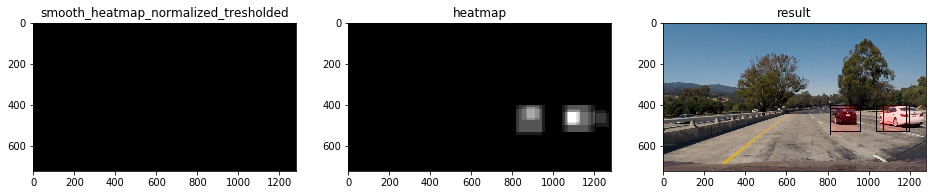

test_images\test2.jpg
(720, 1280, 3)


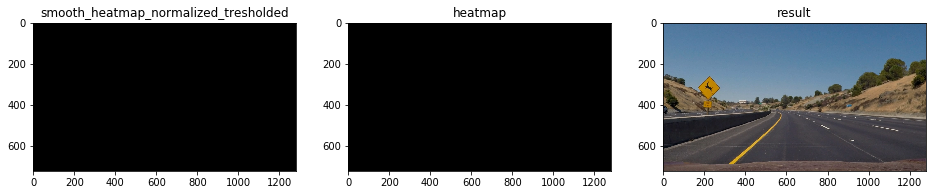

test_images\test3.jpg
(720, 1280, 3)


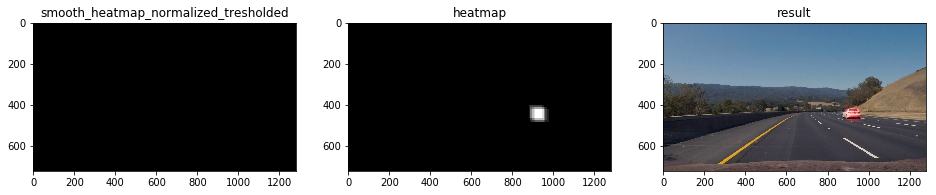

test_images\test4.jpg
(720, 1280, 3)


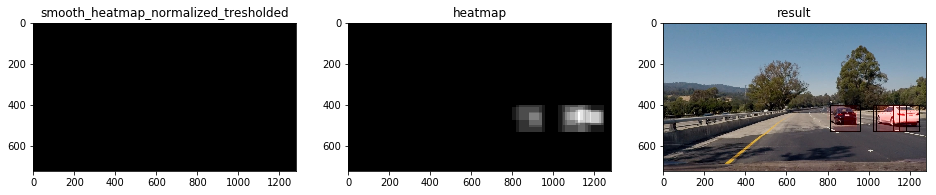

test_images\test5.jpg
(720, 1280, 3)


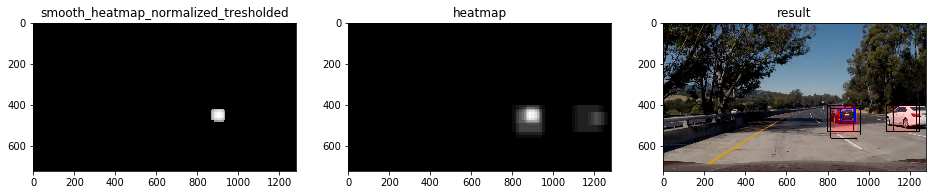

test_images\test6.jpg
(720, 1280, 3)


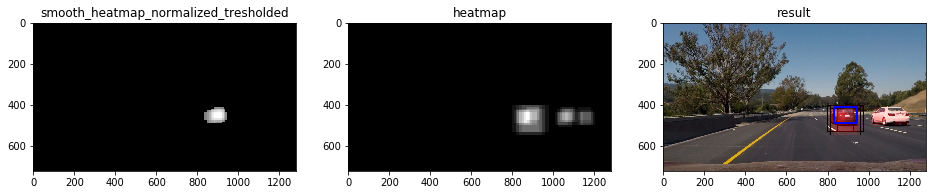

In [ ]:
# Test what you can test on single images...
if visualize or True:
    for path in test_image_paths:
        print(path)
        img = load_image(path,conv=cv2.COLOR_BGR2RGB)
        print(img.shape)
        
        result,heatmap,smooth_heatmap_normalized_tresholded = frame_prozessor.visualize_frame(img)
        #plt.imshow(process_frame_result, cmap='gray')
        #plt.show()
            
        # Plot
        fig = plt.figure(figsize=(16, 6))
        plt.subplot(131)
        plt.imshow(smooth_heatmap_normalized_tresholded, cmap='gray')
        plt.title('smooth_heatmap_normalized_tresholded')
        plt.subplot(132)
        plt.imshow(heatmap, cmap='gray')
        plt.title('heatmap')
        plt.subplot(133)
        plt.imshow(result, cmap='gray')
        plt.title('result')
        plt.show()
        
    

# Video Implementation

In [ ]:
from moviepy.editor import VideoFileClip

def precess_video():
    for video_path in video_paths[-1::-1]:
        print(video_path)
        try:
            frame_prozessor2 = Frame_Prozessor()  # clear previews single frame data from pipeline
            clip = VideoFileClip(video_path).fl_image(frame_prozessor2.process_frame)
            %time clip.write_videofile(video_path[:-4] + '_result.mp4', audio=False)
        finally:
            clip.reader.__del__
            clip.__del__

precess_video()

test_video.mp4
[MoviePy] >>>> Building video test_video_result.mp4
[MoviePy] Writing video test_video_result.mp4


 97%|█████████████████████████████████████████▉ | 38/39 [02:39<00:06,  6.05s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_result.mp4 

Wall time: 2min 48s
project_video.mp4
[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing video project_video_result.mp4


  0%|▏                                       | 6/1261 [00:27<1:36:35,  4.62s/it]

# Discussion

Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust?
	

Discussion includes some consideration of problems/issues faced, what could be improved about their algorithm/pipeline, and what hypothetical cases would cause their pipeline to fail. 


In [ ]:
'''
- Heavy use of pickle was a good practise for saving time.

- Due to limited memory ressources on my tablet i just used a part (every 2. Sample) of the dataset for training and normalizing. 

- The model should benefit from incrieasing the data size.
  The achived Test Accuracy of SVC is 0.9913 and was satisfying for me.
  
- A further option to increase the performance is to argument the dataset.

- Not just sum up car detection to heatmap, also subtract non car detection from heatmap can give better feedback especially in less sure situations and conrners/boarders of the image.

- Like always there could be some room for further parameter & model finetuning.

- Manual adapting giving just a short test seqence has also the risk to build a model that fails generalizing on other data that the given data.

- A short solution for fixing the false & missing detections for given track is to add related datapoints to the (training) dataset. This was not implimented because of the earlyer mentiond concerns about such practice.

- Use Regression instead of Classification to better model uncertainty

'''

# Suggestions to Make Your Project Stand Out!

A stand out submission for this project will be a pipeline that runs in near real time (at least several frames per second on a good laptop) and does a great job of identifying and tracking vehicles in the frame with a minimum of false positives. As an optional challenge, combine this vehicle detection pipeline with the lane finding implementation from the last project! As an additional optional challenge, record your own video and run your pipeline on it to detect vehicles under different conditions.
